In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from source.tserie import TSerie

from source.torch_utils import getContrastiveFeatures

import sys

sys.path.append('/home/texs/Documentos/Repositories/ts2vec')



/home/texs/anaconda3/envs/cuml-torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from source.datasets import loadFuncionalModel, loadNatops, loadWafer, loadSelfRegulationSCP2, loadBasicMotions, loadEarthquakes, loadItalyPowerDemand, loadEigenWorms

dataset = 'basicmotions' # natops | wafer | selfreg | basicmotions | earthquakes | italy | eigenworms

settings = {
    'natops' : {
        'epochs': 150,
        'filters' : [32, 64],
        'kernels' : [5, 5],
        'feat_size' : 256,
        'enc_size' : 20,
    },
    'wafer' : {
        'epochs': 20,
        'filters' : [16, 32],
        'kernels' : [5, 5],
        'feat_size' : 512,
        'enc_size' : 20,
    },
    'basicmotions' : {
        'epochs': 200,
        'filters' : [16, 32],
        'kernels' : [5, 5],
        'feat_size' : 128,
        'enc_size' : 20,
    },
    'italy' : {
        'epochs': 200,
        'filters' : [16],
        'kernels' : [5],
        'feat_size' : 128,
        'enc_size' : 8,
    }
}

if dataset == 'natops':
    X_train, y_train, X_test, y_test, classLabels = loadNatops()
elif dataset == 'wafer':
    X_train, y_train, X_test, y_test = loadWafer()
    classLabels = {}
elif dataset == 'basicmotions':
    X_train, y_train, X_test, y_test, classLabels= loadBasicMotions()
elif dataset == 'italy':
    X_train, y_train, X_test, y_test, classLabels= loadItalyPowerDemand()
# X = np.concatenate([X_train, X_test], axis=0).transpose([0, 2, 1])
# y = np.concatenate([y_train, y_test], axis=0)
# y = np.array([float(v) for v in y]).astype(int).tolist()

In [3]:
mts_train = TSerie(X=X_train.transpose([0, 2, 1]), y=y_train)
mts_test = TSerie(X=X_test.transpose([0, 2, 1]), y=y_test)

Loaded mts - N: 40, T: 100, D: 6 
Loaded mts - N: 40, T: 100, D: 6 


In [4]:
# mts.smooth(window_size=40)
# mts_train.shapeNormalizization()
# mts_test.shapeNormalizization()
# mts_train.minMaxNormalizization()
# mts_test.minMaxNormalizization()
# minl, maxl = mts_train.minMaxNormalizization()
# minl, maxl = mts_test.minMaxNormalizization(minl= minl, maxl=maxl)

In [5]:
from source.featlearn.simclr import SimClrFL
from source.featlearn.weakStrongFL import WeakStrongFL
from ts2vec import TS2Vec

# Train a TS2Vec model
# model = TS2Vec(
#     input_dims=mts_train.D,
#     device=0,
#     output_dims=128,
# )




in_channels = mts_train.D
in_time = mts_train.T
# encoder = SimClrFL(in_channels, in_time)
encoder = SimClrFL(
    in_channels, 
    in_time, 
    encoding_size = 4, 
    feature_size=32, 
    filters = [16, 16, 16],
    kernels = [3, 3, 3],
    # kernels = [16, 16, 16],
    # filters = [5, 5, 5],
)

In [183]:
# encoder.reviewAugmentations(mts_train.X.transpose([0, 2, 1]))

In [6]:
encoder.fit(mts_train.X.transpose([0, 2, 1]), 
            epochs=50, 
            batch_size=32,X_val = mts_test.X.transpose([0, 2, 1]),
)


# loss_log = model.fit(
#     mts_train.X,
#     verbose=True
# )

Epoch[1] Train loss    avg: 4.314742684364319
Epoch[1] Val loss    avg: 3.967381000518799
Epoch[10] Train loss    avg: 2.990684986114502
Epoch[10] Val loss    avg: 2.9007540941238403
Epoch[20] Train loss    avg: 2.6258776783943176
Epoch[20] Val loss    avg: 2.7283451557159424
Epoch[30] Train loss    avg: 2.5084738731384277
Epoch[30] Val loss    avg: 2.5697750449180603
Epoch[40] Train loss    avg: 2.4566155672073364
Epoch[40] Val loss    avg: 2.594030201435089
Epoch[50] Train loss    avg: 2.1222691535949707
Epoch[50] Val loss    avg: 2.496153175830841


In [7]:
print(mts_train.X.max(), mts_test.X.max())
print(mts_train.X.min(), mts_test.X.min())

print(mts_train.X.shape)

34.86621 29.394165
-27.822042 -27.321314
(40, 100, 6)


In [8]:
mts_test.features = encoder.encode(mts_test.X.transpose([0, 2, 1]))
mts_train.features = encoder.encode(mts_train.X.transpose([0, 2, 1]))

# mts_train.features = model.encode(mts_train.X, encoding_window='full_series')
# mts_test.features = model.encode(mts_test.X, encoding_window='full_series')


In [9]:
from sklearn import svm
from sklearn.metrics import f1_score

clf = svm.SVC()
clf.fit(mts_train.features, mts_train.y)

print('accuracy')
print(clf.score(mts_train.features, mts_train.y))
print(clf.score(mts_test.features, mts_test.y))

print('f1 score')
print(f1_score(clf.predict(mts_train.features), mts_train.y, average= 'weighted'))
print(f1_score(clf.predict(mts_test.features), mts_test.y, average= 'weighted'))

accuracy
1.0
0.95
f1 score
1.0
0.95


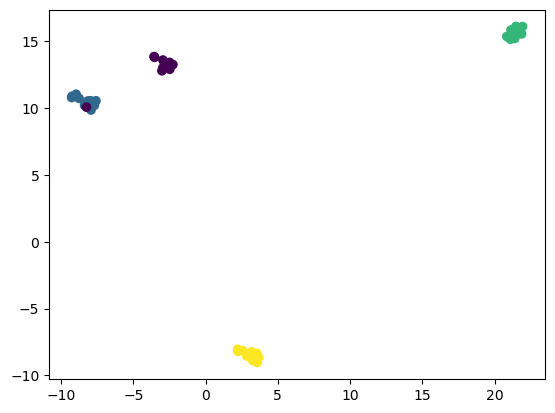

In [10]:
import matplotlib.pyplot as plt
import umap

# reducer = umap.UMAP(n_components=2, metric='cosine')
reducer = umap.UMAP(n_components=2, metric='euclidean', n_neighbors=8)
reducer.fit(mts_train.features, y = mts_train.y)
# reducer.fit(mts_train.features)
coords_train = reducer.transform(mts_train.features)
coords_test = reducer.transform(mts_test.features)

plt.scatter(coords_train[:, 0], coords_train[:, 1], c=mts_train.y)


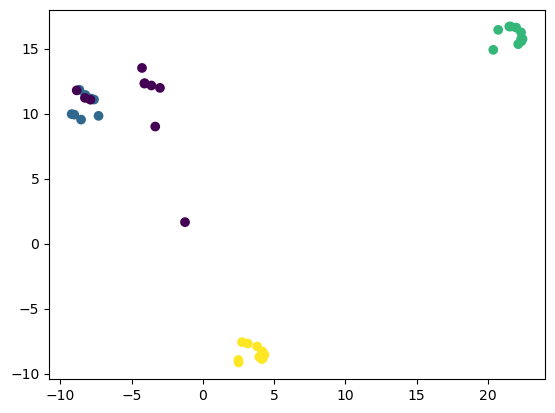

In [11]:
plt.scatter(coords_test[:, 0], coords_test[:, 1],  c=mts_test.y)

In [181]:
import sys
sys.path.append('/home/texs/Documentos/Repositories/mts_viz')
from server.source.storage import MTSStorage

In [160]:
storage = MTSStorage('mts_comparison')    
# storage.delete()
storage.load()

# classLabels = {int(v): str(v) for v in np.unique(y)}
dimensions = [str(dim) for dim in range(mts_train.D)]
# dimensions = [sPoll, sPoll + '_norm']
# dimensions = pollutants + [poll + '_norm' for poll in pollutants]
data = np.concatenate([mts_train.X_orig, mts_train.X], axis=2) 
storage.add_mts(
    '{}_train'.format(dataset),
    data, 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'class': mts_train.y},
    labelsNames = {'class': classLabels},
    coords = {
        'shape': coords_train,
    },
    sampling=True,
    n_samples= 400
)

data = np.concatenate([mts_test.X_orig, mts_test.X], axis=2) 
storage.add_mts(
    '{}_test'.format(dataset),
    data, 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'class': mts_test.y},
    labelsNames = {'class': classLabels},
    coords = {
        'shape': coords_test,
    },
    sampling=True,
    n_samples= 400
)


storage.save()

mts shape: N: 40 -  T: 100 - D: 12
mts shape: N: 40 -  T: 100 - D: 12
